This script test the impact of using different types of spectral constraints to estimate the desired graph. Graphs are generated as grid graphs where each node has 4 neighbors except those nodes on the borders. The error of the recovered graph is computed as the number of samples increases.

In [1]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

import utils
import spectral_nti as snti

# %matplotlib qt

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)

## Auxiliary functions

In [2]:
def est_graph(id, models, MM, X, iters):
    N = X.shape[0]
    A_hat = np.zeros((N, N, len(models), len(MM)))
    lamd_hat = np.zeros((N, len(models), len(MM)))
    for i,M in enumerate(MM):
        C_hat = X[:,:M]@X[:,:M].T/M

        # Individual standard constraints
        for j, model in enumerate(models):
            t = time.time()
            L_hat, lamd_hat[:,j,i] = utils.est_graph(C_hat, model, iters) 
            A_hat[:,:,j,i] = np.diag(np.diag(L_hat)) - L_hat
            t = time.time() - t
            print('Cov-{}, M-{}: Model: {} - Time(sec): {:.3}'.format(id, M, model['name'], t))
    return A_hat, lamd_hat


def est_errs1(A_hat, lamd_hat, th, A, lambdas):
    L = np.diag(np.sum(A,0)) - A
    norm_A = np.linalg.norm(A,'fro')
    norm_lamb = np.linalg.norm(lambdas)
    norm_L = np.linalg.norm(L,'fro')
    
    err_A = np.zeros(A_hat.shape[2:])
    err_L = np.zeros(A_hat.shape[2:])
    err_A_bin = np.zeros(A_hat.shape[2:])
    err_lamb = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):
                L_hat = np.diag(np.sum(A_hat[:,:,j,i,k],0)) - A_hat[:,:,j,i,k]
                A_bin = np.where(A_hat[:,:,j,i,k] >= th,1,0)

                err_A[j,i,k] = np.linalg.norm(A-A_hat[:,:,j,i,k],'fro')**2/norm_A**2
                err_L[j,i,k] = np.linalg.norm(L-L_hat,'fro')**2/norm_L**2
                err_A_bin[j,i,k] = np.linalg.norm(A-A_bin,'fro')**2/norm_A**2
                err_lamb[j,i,k] = np.linalg.norm(lambdas-lamd_hat[:,j,i,k],2)**2/norm_lamb**2
    return err_A, err_A_bin, err_L, err_lamb


def est_errs2(A_hat, lamd_hat, A, lambdas):
    L = np.diag(np.sum(A,0)) - A
    norm_A = np.linalg.norm(A,'fro')
    norm_lamb = np.linalg.norm(lambdas)
    norm_L = np.linalg.norm(L,'fro')

    err_A = np.zeros(A_hat.shape[2:])
    err_lamb = np.zeros(A_hat.shape[2:])
    err_L = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):
                L_hat = np.diag(np.sum(A_hat[:,:,j,i,k],0)) - A_hat[:,:,j,i,k]
                if np.all((A_hat[:,:,j,i,k] == 0)):
                    norm_A_hat = 1
                    norm_L_hat = 1
                    norm_lamb_hat = 1
                else:
                    norm_A_hat = np.linalg.norm(A_hat[:,:,j,i,k], 'fro')
                    norm_L_hat = np.linalg.norm(L_hat, 'fro')
                    norm_lamb_hat = np.linalg.norm(lamd_hat[:,j,i,k], 2)

                A_hat_norm = A_hat[:,:,j,i,k]/norm_A_hat
                L_hat_norm = L_hat/norm_L_hat
                lam_hat_norm = lamd_hat[:,j,i,k]/norm_lamb_hat
                err_A[j,i,k] = np.linalg.norm(A/norm_A-A_hat_norm,'fro')**2
                err_L[j,i,k] = np.linalg.norm(L/norm_L-L_hat_norm,'fro')**2
                err_lamb[j,i,k] = np.linalg.norm(lambdas/norm_lamb-lam_hat_norm, 2)**2
    return err_A, err_L, err_lamb


def plot_err(MM, models, err, ylab, semlogy=True, ylim=[]):
    plt.figure()
    for i, model in enumerate(models):
        if semlogy:
            plt.semilogy(MM, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.plot(MM, err[i,:], model['fmt'], label=model['name'],
                     linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('Number of samples')
        plt.ylabel(ylab)
        plt.legend()
        plt.xlim([MM[0], MM[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()


def print_err(MM, models, err):
    mean_err = np.mean(err, 2)
    std = np.std(err, 2)
    for i, M in enumerate(MM):
        print('M:', M)
        for j, model in enumerate(models):
            print('\t{}: mean err: {:.6f} - std: {:.6f}'.
                   format(model['name'], mean_err[j,i], std[j,i]))


## Create graphs

Norm of A: 27.202941017470888
Norm of lambdas: 59.39696961966998


Text(0.5, 1.0, 'True Lambdas, N: 200')

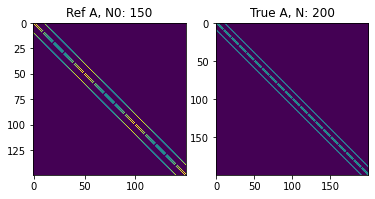

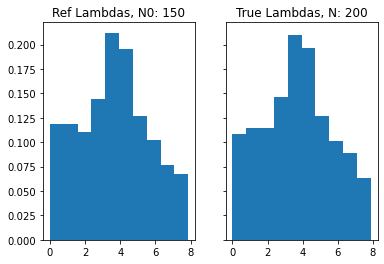

In [3]:
# Ref grap
n01 = 15
n02 = 10
N0 = n01*n02
A0 = nx.to_numpy_array(nx.grid_2d_graph(n01, n02))
L0 = np.diag(np.sum(A0, 0)) - A0
lambdas0, _ = np.linalg.eigh(L0)

# Target graph
n1 = 20
n2 = 10
N = n1*n2
A = nx.to_numpy_array(nx.grid_2d_graph(n1, n2))
L = np.diag(np.sum(A, 0)) - A
lambdas, V = np.linalg.eigh(L)

norm_A = np.linalg.norm(A,'fro')
norm_lamb = np.linalg.norm(lambdas)

print('Norm of A:', norm_A)
print('Norm of lambdas:', norm_lamb)

# Plot graphs and spectrum distribution
plt.figure()
plt.subplot(1,2,1)
plt.imshow(A0)
plt.title('Ref A, N0: ' + str(N0))
plt.subplot(1,2,2)
plt.imshow(A)
plt.title('True A, N: ' + str(N))
    
figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(lambdas0, density=True)
axs[0].set_title('Ref Lambdas, N0: ' + str(N0))
axs[1].hist(lambdas, density=True)
axs[1].set_title('True Lambdas, N: ' + str(N))

## Compare contraints

In [4]:
n_covs = 50
MM = np.arange(300, 1501, 100)
iters = 100

GS = [
    lambda a, b : cp.sum(a)/b,    # delta: 4e-2
    lambda a, b : cp.sum(a**2)/b,  # delta: .7
    lambda a, b : cp.sum(cp.exp(-a))/b,    # delta: 3e-3
    lambda a, b : cp.sum(cp.sqrt(a))/b,  # delta: 2e-2
    lambda a, b : cp.sum(.25*a**2-.75*a)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b : cp.sum(lamd/cp.sqrt(lamd_t))/(2*b),
    lambda lamd, lamd_t, b: 1/b*(0.75-2*0.25*lamd_t).T@lamd,
]

deltas = [.04, .27, .003, .02, 0.05]
cs, err_cs = utils.compute_cs(GS, lambdas0, lambdas, verbose=True)

models = [
    {'name': 'Unc', 'gs': [], 'bounds': [], 'cs': [], 'fmt': '1-',
     'regs': {'alpha': .01, 'beta': 1.75, 'gamma': 0, 'deltas': []}},
   
    {'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 0, 'deltas': deltas[0]}},

    {'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o-',
     'regs': {'alpha': .0, 'beta': 1.25, 'gamma': 1000, 'deltas': deltas[1]}},

    {'name': 'Heat', 'gs': GS[2], 'bounds': BOUNDS[1], 'cs': cs[2], 'fmt': 'x-',
     'regs': {'alpha': .001, 'beta': .4, 'gamma': 100, 'deltas': deltas[2]}},

    {'name': 'Sqrt', 'gs': GS[3], 'bounds': BOUNDS[2], 'cs': cs[3], 'fmt': 'v-',
     'regs': {'alpha': .01, 'beta': .5, 'gamma': 25, 'deltas': deltas[3]}},

    {'name': 'Poly', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 1000, 'deltas': deltas[4]}},
]

	c-0: c: 3.700	c0: 3.667	err: 0.033333	err norm: 0.009091
	c-1: c: 17.640	c0: 17.387	err: 0.253333	err norm: 0.014571
	c-2: c: 0.114	c0: 0.115	err: -0.001259	err norm: -0.010911
	c-3: c: 1.828	c0: 1.817	err: 0.010217	err norm: 0.005622
	c-4: c: 1.635	c0: 1.597	err: 0.038333	err norm: 0.024008
[ 3.66666667 17.38666667  0.11535504  1.81741401  1.59666667]


In [5]:
# Create signals
lambdas_aux = np.concatenate(([0], 1/np.sqrt(lambdas[1:])))
C_inv_sqrt = V@np.diag(lambdas_aux)@V.T
X = C_inv_sqrt@np.random.randn(n_covs, N, MM[-1])

# Estimate graph
total_t = time.time()
As_hat = np.zeros((N, N, len(models), len(MM), n_covs))
lamds_hat = np.zeros((N, len(models), len(MM), n_covs)) 

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(est_graph)(i, models, MM, X[i,:,:], iters) for i in range(n_covs))
for i, resp in enumerate(resps):
    As_hat[:,:,:,:,i], lamds_hat[:,:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
----- 3.3856438398361206  mins -----


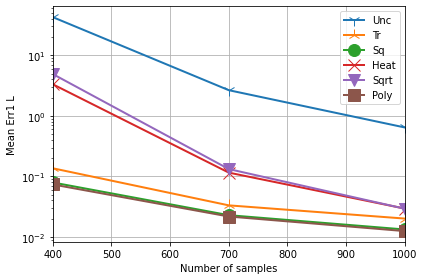

In [6]:
# Plot error 1
th = .3
err_A, err_A_bin, err_L, err_lamb = est_errs1(As_hat, lamds_hat, th, A, lambdas)
mean_err = np.mean(err_A, 2)
mean_err_L = np.mean(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM[:], models, mean_err_L[:,:], 'Mean Err1 L')


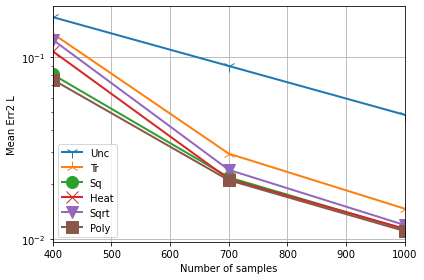

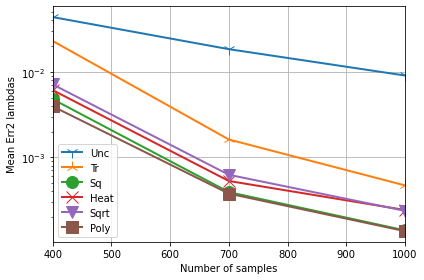

In [7]:
err_A, err_L, err_lamb = est_errs2(As_hat, lamds_hat, A, lambdas)
mean_err = np.mean(err_A, 2)
mean_err_L = np.median(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM, models, mean_err_L, 'Mean Err2 L')
plot_err(MM, models, mean_err_lam, 'Mean Err2 lambdas')

In [8]:
# Save data
models_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': model['regs']}
                for model in models]
data = {
    'A': A,
    'lambdas': lambdas,
    'As_hat': As_hat,
    'lamds_hat': lamds_hat,
    'MM': MM,
    'models': models_aux
}
file = 'constraints_{}covs_{}iters'.format(n_covs, iters)
# np.save('results/constraints/' + file, data)
np.save('results/constraints/tmp', data)

In [9]:
# # Load data
# file = 'results/constraints/constraints_50covs_100iters.npy'
# data = np.load(file, allow_pickle=True).item()
# models = data['models']

# A = data['A']
# lambdas = data['lambdas']
# As_hat = data['As_hat']
# lamds_hat = data['lamds_hat']
# MM = data['MM']
# models = data['models']

In [31]:
print(lambdas[1:].min())
print(lambdas[1:].max())

0.024623318809724442
7.877489713780582


## Compare with baselines

In [25]:
n_covs = 50
MM = np.arange(300, 1501, 100)
iters = 100

models = [
    {'name': 'Unc', 'gs': [], 'bounds': [], 'cs': [], 'fmt': '1--',
     'regs': {'alpha': .01, 'beta': 1.75, 'gamma': 0, 'deltas': 0}},
    {'name': 'GLasso', 'alpha': 0.01, 'fmt': '^--'},
    {'name': 'MGL-Tr=1', 'gs': GS[0], 'bounds': [], 'cs': 1, 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': 2, 'gamma': 0, 'deltas': deltas[0]}},
    {'name': 'SGL', 'fmt': '*--', 
     'regs': {'alpha': 0, 'beta': 2, 'c1': .001, 'c2': 20, 'conn_comp': 1}},
   
    {'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 0, 'deltas': deltas[0]}},
    {'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o-',
     'regs': {'alpha': .0, 'beta': 1.25, 'gamma': 1000, 'deltas': deltas[1]}},
    {'name': 'Heat', 'gs': GS[2], 'bounds': BOUNDS[1], 'cs': cs[2], 'fmt': 'x-',
     'regs': {'alpha': .001, 'beta': .4, 'gamma': 100, 'deltas': deltas[2]}},
]

In [26]:
# Create signals
lambdas_aux = np.concatenate(([0], 1/np.sqrt(lambdas[1:])))
C_inv_sqrt = V@np.diag(lambdas_aux)@V.T
X = C_inv_sqrt@np.random.randn(n_covs, N, MM[-1])

# Estimate graph
total_t = time.time()
As_hat2 = np.zeros((N, N, len(models), len(MM), n_covs))
lamds_hat2 = np.zeros((N, len(models), len(MM), n_covs)) 

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(est_graph)(i, models, MM, X[i,:,:], iters) for i in range(n_covs))
for i, resp in enumerate(resps):
    As_hat2[:,:,:,:,i], lamds_hat2[:,:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
----- 3.6528287569681805  mins -----


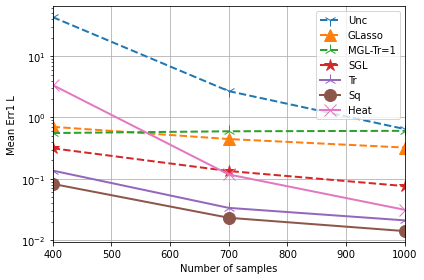

In [ ]:
# Plot error 1
th = .3
err_A, err_A_bin, err_L, err_lamb = est_errs1(As_hat2, lamds_hat2, th, A, lambdas)
mean_err = np.mean(err_A, 2)
mean_err_L = np.mean(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM[:], models, mean_err_L[:,:], 'Mean Err1 L')


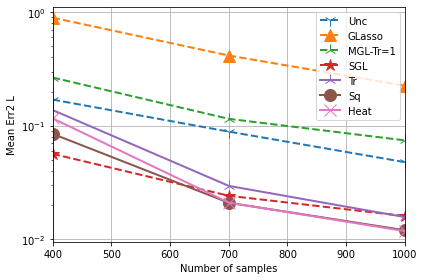

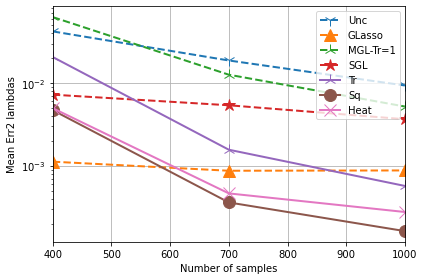

In [22]:
err_A, err_L, err_lamb = est_errs2(As_hat2, lamds_hat2, A, lambdas)
mean_err = np.mean(err_A, 2)
mean_err_L = np.median(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM, models, mean_err_L, 'Mean Err2 L')
plot_err(MM, models, mean_err_lam, 'Mean Err2 lambdas')

In [23]:
# Save data
models_aux = [{'name': model['name'], 'fmt': model['fmt']} 
                for model in models]
data = {
    'A': A,
    'lambdas': lambdas,
    'As_hat': As_hat,
    'lamds_hat': lamds_hat,
    'MM': MM,
    'models': models_aux
}
file = 'models_{}covs_{}iters'.format(n_covs, iters)
# np.save('results/constraints/' + file, data)
np.save('results/constraints/tmp2', data)